In [41]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import os
import json
import librosa
from keras.models import Sequential
from keras.layers import Dense
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow import keras
from keras.layers import Dropout
import keras
from IPython.display import clear_output

In [10]:
print("yash")

yash


In [11]:
SOURCE_PATH = 'genres_emotion/'
JSON_PATH = 'data.json'
sr = 22050
TOTAL_SAMPLES = 29 * sr
NUM_SLICES = 10
SAMPLES_PER_SLICE = int(TOTAL_SAMPLES / NUM_SLICES)

In [12]:
def preprocess_data(source_path, json_path):
    mydict = {
        "labels": [],
        "mfcc": []
    }
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(source_path)):
        for file in filenames:
            song, sr = librosa.load(os.path.join(dirpath, file), duration=29)
            for s in range(NUM_SLICES):
                start_sample = SAMPLES_PER_SLICE * s
                end_sample = start_sample + SAMPLES_PER_SLICE
                mfcc = librosa.feature.mfcc(y=song[start_sample:end_sample], sr=sr, n_mfcc=13)
                mfcc = mfcc.T
                mydict["labels"].append(i-1)
                mydict['mfcc'].append(mfcc.tolist())
    
    with open(json_path, 'w') as f:
        json.dump(mydict, f)
    f.close()

In [13]:
def load_data(json_path):

    with open(json_path, 'r') as f:
        data = json.load(f)
    f.close()

    # Let's load our data into numpy arrays for TensorFlow compatibility.
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    return X, y

In [14]:
preprocess_data(source_path=SOURCE_PATH, json_path=JSON_PATH)

In [15]:
for i, (dirpath, dirnames, filenames) in enumerate(os.walk(SOURCE_PATH)):
    print(i)
    print(dirpath)
    print(dirnames)
    print(filenames)

0
genres_emotion/
['angry', 'calm', 'happy', 'sad']
[]
1
genres_emotion/angry
[]
['blues.00016.wav', 'blues.00019.wav', 'blues.00040.wav', 'blues.00041.wav', 'blues.00042.wav', 'blues.00043.wav', 'blues.00044.wav', 'blues.00053.wav', 'blues.00054.wav', 'blues.00062.wav', 'blues.00066.wav', 'blues.00070.wav', 'blues.00071.wav', 'blues.00074.wav', 'blues.00078.wav', 'blues.00079.wav', 'blues.00081.wav', 'blues.00094.wav', 'classical.00018.wav', 'classical.00020.wav', 'classical.00021.wav', 'classical.00022.wav', 'classical.00024.wav', 'classical.00025.wav', 'classical.00026.wav', 'classical.00037.wav', 'classical.00042.wav', 'classical.00049.wav', 'classical.00053.wav', 'classical.00054.wav', 'classical.00055.wav', 'classical.00056.wav', 'classical.00081.wav', 'classical.00082.wav', 'classical.00083.wav', 'classical.00084.wav', 'classical.00085.wav', 'classical.00086.wav', 'classical.00087.wav', 'classical.00088.wav', 'classical.00089.wav', 'classical.00096.wav', 'classical.00097.wav', '

In [16]:
def prepare_datasets(inputs, targets, split_size):
    
    # Creating a validation set and a test set.
    inputs_train, inputs_val, targets_train, targets_val = train_test_split(inputs, targets, test_size=split_size)
    inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs_train, targets_train, test_size=split_size)
    
    # Our CNN model expects 3D input shape.
    inputs_train = inputs_train[..., np.newaxis]
    inputs_val = inputs_val[..., np.newaxis]
    inputs_test = inputs_test[..., np.newaxis]
    
    return inputs_train, inputs_val, inputs_test, targets_train, targets_val, targets_test

In [120]:
def design_model(input_shape):

    # Let's design the model architecture.
    model = tf.keras.models.Sequential([
        
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(32, (2,2), activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'), 
        
        tf.keras.layers.Dense(len(np.unique(targets)), activation='softmax')
    ])

    return model

In [121]:
def make_prediction(model, X, y, idx):
    
    genre_dict = {
        0 : "angry",
        1 : "calm",
        2 : "happy",
        3 : "sad",
        }
        
    predictions = model.predict(X)
    genre = np.argmax(predictions[idx])
    
    print("\n---Now testing the model for one audio file---\nThe model predicts: {}, and ground truth is: {}.\n".format(genre_dict[genre], genre_dict[y[idx]]))

In [122]:
def plot_performance(hist):
    fig , ax = plt.subplots(1,2)
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs = range(len(acc))
    fig.set_size_inches(20,6)
    ax[0].plot(epochs, acc, 'r', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    #ax[0].figure()

    ax[1].plot(epochs, loss, 'r', label='Training Loss')
    ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()

    plt.show()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 123, 11, 32)       320       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 62, 6, 32)         0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 62, 6, 32)         128       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 60, 4, 32)         9248      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 30, 2, 32)         0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 30, 2, 32)         128       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 29, 1, 32)        

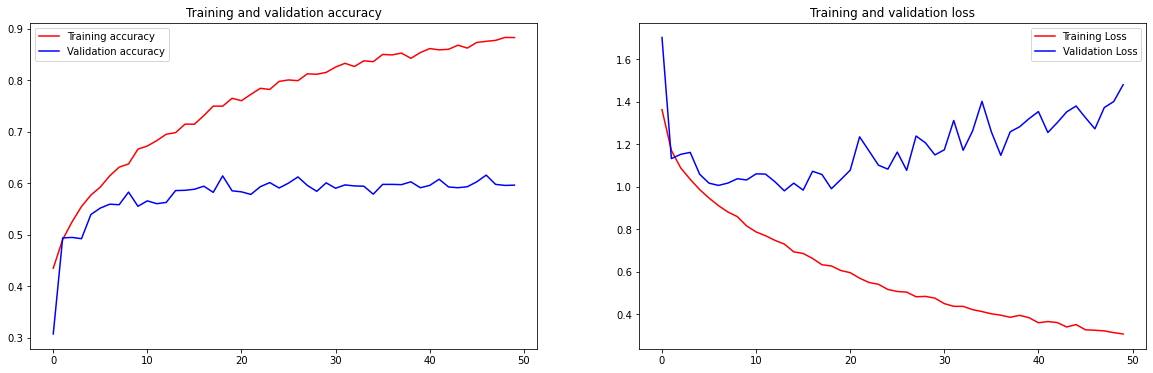


---Now testing the model for one audio file---
The model predicts: happy, and ground truth is: happy.



In [123]:
if __name__ == "__main__":

    #preprocess_data(source_path=SOURCE_PATH, json_path=JSON_PATH)
    
    inputs, targets = load_data(json_path=JSON_PATH)
    
    Xtrain, Xval, Xtest, ytrain, yval, ytest = prepare_datasets(inputs, targets, 0.2)

    input_shape = (Xtrain.shape[1], Xtrain.shape[2], 1)
    model = design_model(input_shape)

    # Selection of the optimizer, loss type and metrics for performance evaluation.
    model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001),
                     loss='sparse_categorical_crossentropy',
                     metrics = ['acc']
                     )

    model.summary()

    #Training the model.
    history = model.fit(Xtrain, ytrain,
                        validation_data=(Xval, yval),
                        epochs=50,
                        batch_size=64
                        )

    plot_performance(history)

    # Testing the model on never seen before data.
    make_prediction(model, Xtest, ytest, 24)

In [124]:
make_prediction(model, Xtest, ytest, 50)


---Now testing the model for one audio file---
The model predicts: calm, and ground truth is: calm.



In [125]:
y_pred = model.predict(Xtest)
yp = []
for i in y_pred:
    genre1 = np.argmax(i)
    yp.append(genre1)

In [126]:
c4=model.evaluate(Xtest,ytest)
accuracy = c4*100


50/50 [==============================] - 0s 5ms/step - loss: 1.4637 - acc: 0.6131


In [127]:
Xtrain.shape

(6400, 125, 13, 1)

In [128]:
genr = ["angry","calm","happy","sad"]

In [129]:
genre_dict = {
        0 : "angry",
        1 : "calm",
        2 : "happy",
        3 : "sad",
        }

In [130]:
ytest.shape

(1600,)

In [131]:
ytest_n = []
yp_n = []
for i in range(ytest.shape[0]):
    ytest_n.append(genre_dict[ytest[i]])
    yp_n.append(genre_dict[yp[i]])

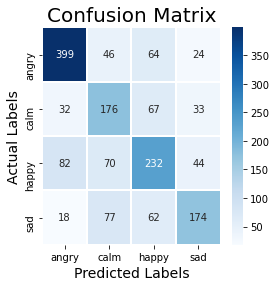

In [132]:
cm = confusion_matrix(ytest, yp)
plt.figure(figsize = (4, 4))
cm = pd.DataFrame(cm , index = [i for i in genr] , columns = [i for i in genr])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [133]:
print(classification_report(ytest_n, yp_n))

              precision    recall  f1-score   support

       angry       0.75      0.75      0.75       533
        calm       0.48      0.57      0.52       308
       happy       0.55      0.54      0.54       428
         sad       0.63      0.53      0.57       331

    accuracy                           0.61      1600
   macro avg       0.60      0.60      0.60      1600
weighted avg       0.62      0.61      0.61      1600



In [137]:
import visualkeras

In [139]:
from keras.models import load_model

model.save('my_model.h5')